# SVM

Objective: Build a model to predict if a single compound is a "PPI modulator" or is not.

Data: ADME descriptors for 3 libraries.
    Libraries:
        AFRODB
        Biofacquim
        FDA
        PPI
        
        
    Endpoint: "PPI modulator" (Binary)
        1 -> PPI modulator
        0 -> Not PPI modulator
        
    Descriptors
        ADME descriptors:
            '#Aromatic heavy atoms'
            '#H-bond acceptors'
            '#H-bond donors'
            '#Heavy atoms'
             
Method: Support Vector Machine

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import os

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from Functions_SVM import get_atributes, test_compound,test_compound_real_category, svm_report, plot_roc

In [2]:
descriptors = ['HBA', 'HBD', 'RB', 'LogP', 'TPSA', 'MW', 'Heavy Atom', 'Ring Count', 'Fraction CSP3']
#Falta generar los descriptores

In [3]:
#Difacquim computer root
root = {"root": "/home/barbara/Documents/DIFACQUIM/PPI_classifier/phase-1/Databases/",
        "root_Info" : "/home/barbara/Documents/DIFACQUIM/PPI_classifier/phase-1/Supervised_Models/SVM/Info",
        "root_ROC" : "/home/barbara/Documents/DIFACQUIM/PPI_classifier/phase-1/Supervised_Models/SVM/ROC"}

In [4]:
class SVM:
    
    def __init__(self, root, input_file, target, descriptors, fraction):
        self.Data  = pd.read_csv(str(root["root"]) + str(input_file))
        #Muestreo
        self.Data = pd.DataFrame.sample(self.Data, frac=0.1, replace=True,  random_state=1992, axis=None) 
        self.fraction = fraction
        print(self.Data.PPI.unique())
        print("Libraries are: ", self.Data.Library.unique())
        #print("PPI modulator: ", self.Data[target].unique())
        print("Total compounds ", self.Data.shape[0])
        self.descriptors = descriptors
        self.target = target
        self.root = root
        
    def train_model(self, kernel, class_weight):
        """
        kernel: str, ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ )
        class_weight : ‘balanced’
        """
        y = np.array(self.Data[self.target])
        y = label_binarize(y, classes = ["No", "Yes"])
        X_train, X_test, y_train, y_test = train_test_split(self.Data[self.descriptors], y, test_size = self.fraction,random_state=1992)
        model = SVC(kernel = kernel, probability=True, cache_size = 16,  class_weight =  class_weight, random_state=1992)
        print(model)
        model.fit(X_train, y_train)
        self.atributes = get_atributes(kernel, model)
        #print(self.atributes)
        self.parameters = { "Method": "Linear Regression",
                            "Class weight": class_weight,
                            "kernel": kernel,
                            "fraction" : self.fraction * 100}
        self.predictions = {"predictions": model.predict(X_test),
                            "y_score": model.decision_function(X_test),
                            "X_text": X_test,
                            "y_test": y_test}
        self.model = model  
                        
    def single_prediction(self, Library, Name, target):
        compound = test_compound(self.Data, Library, Name, self.descriptors)   
        result = test_compound_real_category(self.Data, Name, target)
        print("Evaluation of ", str(Name))
        print("Predicted activity value: ", str(self.model.predict(compound)))
        print("Real activity value", result)
    
    def report(self, ref_output):
        roc_auc = plot_roc(ref_output,self.predictions["y_test"], self.predictions["y_score"], self.root["root_ROC"])
        r = svm_report(ref_output, self.Data, self.parameters, self.predictions["y_test"], self.predictions["predictions"], self.descriptors, self.atributes,roc_auc, self.root["root_Info"])


In [5]:
a = SVM(root, "Dataset.csv", "PPI", descriptors, 0.3)

['No' 'Yes']
Libraries are:  ['Epidatabase' 'FDA' 'PPI' 'AFRODB' 'BIOFACQUIM']
Total compounds  2108


In [10]:
a.train_model('linear', "balanced")

SVC(C=1.0, cache_size=16, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=1992,
    shrinking=True, tol=0.001, verbose=False)


/home/barbara/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
#a.single_prediction("PPI", "1602", "PPI")

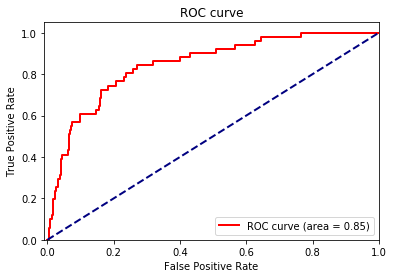

/home/barbara/Documents/DIFACQUIM/PPI_classifier/phase-1/Supervised_Models/SVM/Functions_SVM.py:120: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  Report.to_csv(str(root_Info) + "/SVM_"+str(ref_output)+".csv", sep = ",")


In [12]:
a.report("MyfirstSVM2")

In [9]:
#Identify Numerical Data (Descriptors)
def numerical_descriptors(DataFrame):
    print(DataFrame.select_dtypes(np.number).columns)